# Graduation Lab
### Mason Nicoletti


Instructions:

Let's build a kNN model using the college completion data. 
The data is messy and you have a degrees of freedom problem, as in, we have too many features.  

You've done most of the hard work already, so you should be ready to move forward with building your model.

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 62 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   unitid                                3798 non-null   int64  
 1   chronname                             3798 non-null   object 
 2   city                                  3798 non-null   object 
 3   state                                 3798 non-null   object 
 4   level                                 3798 non-null   object 
 5   control                               3798 non-null   object 
 6   basic                                 3798 non-null   object 
 7   hbcu                                  94 non-null     object 
 8   flagship                              50 non-null     object 
 9   long_x                                3798 non-null   float64
 10  lat_y                                 3798 non-null   float64
 11  site             

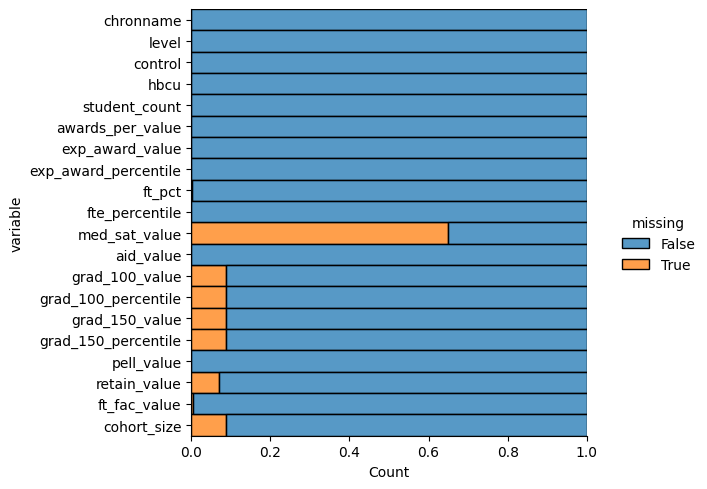

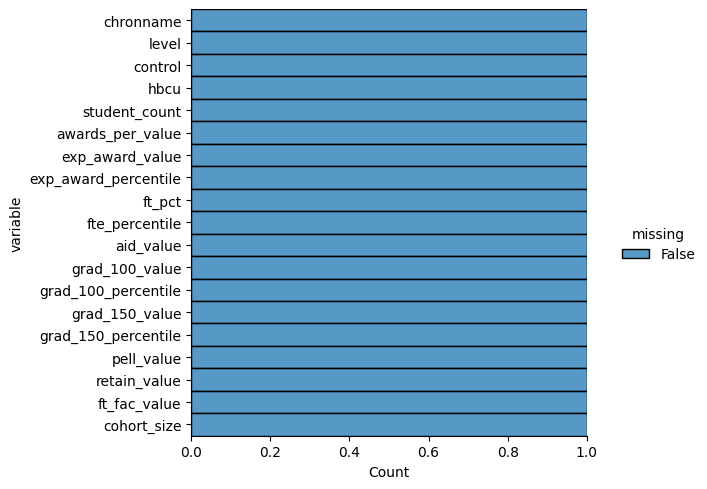

In [148]:
# Data Cleaning

grad_data = pd.read_csv('https://query.data.world/s/qpi2ltkz23yp2fcaz4jmlrskjx5qnp', encoding="cp1252")
# the encoding part here is important to properly read the data! It doesn't apply to ALL csv files read from the web,
# but it was necessary here.
grad_data.info()

# We have a lot of data! A lot of these have many missing values or are otherwise not useful.
to_drop = list(range(39, 56))
to_drop.extend([27, 9, 10, 11, 28, 36, 60, 56])

grad_data1 = grad_data.drop(grad_data.columns[to_drop], axis=1)
grad_data1.info()

# drop even more data that doesn't look predictive
drop_more = [0,2,3,6,8,11,12,14,15,18,21,23,29,32,33,34,35]
grad_data2 = grad_data1.drop(grad_data1.columns[drop_more], axis=1)
grad_data2.info()

print(grad_data2.head())

grad_data2.replace('NULL', np.nan, inplace=True)

grad_data2['hbcu'] = [1 if grad_data2['hbcu'][i]=='X' else 0 for i in range(len(grad_data2['hbcu']))]
grad_data2['hbcu'].value_counts()

grad_data2['hbcu'] = grad_data2.hbcu.astype('category')
# convert more variables to factors
grad_data2[['level', 'control']] = grad_data2[['level', 'control']].astype('category')

# In R, we convert vals to numbers, but they already are in this import
grad_data2.info()

# check missing data
sns.displot(
    data=grad_data2.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

#let's drop med_stat_value then delete the rest of the NA rows
grad_data2 = grad_data2.drop(grad_data[['med_sat_value']], axis=1)
grad_data2.dropna(axis = 0, how = 'any', inplace = True)

sns.displot(
    data=grad_data2.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [149]:
# Question 1

'''
Use the question/target variable you submitted and build a model to answer the question you created for this dataset. 

College Completion Data
Question: What factors are the greatest predictors of colleges with 4-year graduation rates that are in the highest percentile?
    - (Top 90% 4-Year Graduation Rate)
'''

# Drop unnecessary columns
drop_columns = [0, 1, 11, 13, 14]
grad_data3 = grad_data2.drop(columns = grad_data2.columns[drop_columns], axis = 1)

# Standardize numeric data
numeric_columns = list(grad_data3.select_dtypes('number'))
grad_data3[numeric_columns] = MinMaxScaler().fit_transform(grad_data3[numeric_columns])

# One-Hot Encoding
grad_categories = list(grad_data3.select_dtypes('category'))
grad_data3 = pd.get_dummies(grad_data3, columns = grad_categories, drop_first = True)

# Set graduation rate above 90% as the target variable
grad_data3['grad_rate_90'] = pd.cut(grad_data3.grad_100_percentile, bins = [-1, 0.90, 1], labels = [0,1])

# Drop the old graduation rate column
grad_data3 = grad_data3.drop(['grad_100_percentile'], axis = 1)

# Calculate the prevalence of the target variable
prevalence = (grad_data3.grad_rate_90.value_counts()) / len(grad_data3.grad_rate_90)

# Define feature and target variables
x = grad_data3.drop(['grad_rate_90'], axis = 1)
y = grad_data3['grad_rate_90']

# Partitioning the data
# Create a Training and Testing data set stratified by the target variable
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
coef = model.coef_
intercept = model.intercept_

coef_table = pd.DataFrame({"Intercept":intercept, "Coefficients": coef}, index=x.columns)

print(coef_table)


                                Intercept  Coefficients
student_count                   -0.036141     -0.138098
awards_per_value                -0.036141      0.534901
exp_award_value                 -0.036141      3.457050
exp_award_percentile            -0.036141     -0.028714
ft_pct                          -0.036141     -0.088568
fte_percentile                  -0.036141     -0.106806
aid_value                       -0.036141      0.530368
pell_value                      -0.036141     -0.166379
retain_value                    -0.036141      0.218295
ft_fac_value                    -0.036141      0.061641
cohort_size                     -0.036141      0.480182
control_Private not-for-profit  -0.036141     -0.207964
control_Public                  -0.036141     -0.054141
hbcu_1                          -0.036141     -0.001407


Question 1

To answer the question: "What factors are the greatest predictors of colleges with 4-year graduation rates that are in the highest percentile?"

The greatest predicting factors of high graduation rates at a college are `awards_per_value`, `exp_award_value`, `aid_value`, and `cohort_size`, although these factors don't have very large of an influence on predicting four-year graduation rates.

In [150]:
# Question 2

'''
Build and optimize a kNN model to predict your target variable. 
Meaning use the train set to select the correct k value. 
Make sure it is a classification problem, meaning if needed changed the target variable.

New target variable:
- Control: 
    - public 
    - private

New Question:
- Given college data, can we predict which universities are public?

'''


#grad_data2.info()
grad_data4 = grad_data2.drop(['chronname'], axis=1)
grad_data4['control'] = grad_data4['control'].apply(lambda x: x if x == "Public" else "Private")

# Determine the prevalence of the target variable
prevalence = (grad_data4['control'].value_counts() / len(grad_data4))[1]

# Split the data
train, test = train_test_split(grad_data4, train_size=0.8, stratify=grad_data4['control'], random_state = 45)

# Calculate prevalence of the target variable
test, val = train_test_split(test, test_size=0.5, stratify=test['control'], random_state = 45)

# Set feature and target variables
x_train = train.drop(['control'], axis=1)
x_test = test.drop(['control'], axis=1)
y_train = train['control']
y_test = test['control']

# One Hot Encoding
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

# Standardize the Data
numeric_columns = x_train.select_dtypes(include='number').columns
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train[numeric_columns])
x_test = scaler.fit_transform(x_test[numeric_columns])

# Set up validation data
x_val = val.drop(['control'], axis=1)
y_val = val['control']
x_val = pd.get_dummies(x_val)
x_val = scaler.fit_transform(x_val[numeric_columns])

# Perform kNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

# Check Model Accuracy
accuracy = knn.score(x_test, y_test)
val_accuracy = knn.score(x_val, y_val)

# Predict model on test set
pred = knn.predict(x_test)


print("Validation Data Accuracy:", val_accuracy)


Validation Data Accuracy: 0.9704142011834319


/tmp/ipykernel_3163/245585674.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prevalence = (grad_data4['control'].value_counts() / len(grad_data4))[1]


In [151]:
# Question 3

'''
Create a dataframe that includes the test target values, test predicted values, and test probabilities of the positive class.
'''

# Test target values
# y_test

# Test predicted values
pred = knn.predict(x_test)

# Test probabilities of the positive class
prob = knn.predict_proba(x_test)[:,1]

# Create dataframe
knn_df = pd.DataFrame({"Test Target Values": y_test,
                       "Test Predicted Values": pred, 
                       "Test Probabilities of Positive Class": prob})

print(knn_df.head())

     Test Target Values Test Predicted Values  \
315              Public                Public   
1245             Public                Public   
2229             Public                Public   
1092             Public                Public   
1617             Public                Public   

      Test Probabilities of Positive Class  
315                                    1.0  
1245                                   1.0  
2229                                   1.0  
1092                                   1.0  
1617                                   1.0  


Question 4

*No code question: If you adjusted the k hyperparameter what do you think would happen to the threshold function? Would the confusion look the same at the same threshold levels or not? Why or why not?*

Adjusting the number of neighbors (k) affects the threshold function because the value of k determines how sensitive the model is to data after being trained by the training data. For instance, a greater k value than 3 will likely lead to a less sensitive model, leading to a higher specificity (true negatives) but may reduce sensitivity (true positives). Overall, fewer positive instances may be correctly classified. As k is altered, the confusion matrix may look different at the same threshold levels due to changes in the sensitivity and specificity of the model. Ranging k values will impact how much of the test data fall above or below the threshold.

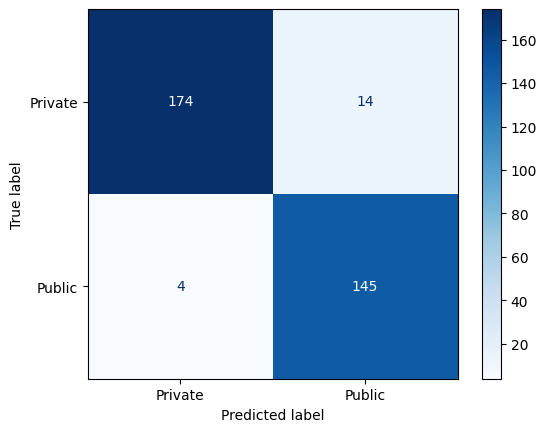

In [152]:
# Question 5

'''
Evaluate the results using the confusion matrix. 
Then "walk" through your question, summarize what concerns or positive elements do you have about the model as it relates to your question? 
'''

# Make a confusion matrix
cm = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
cm_display.plot(cmap='Blues')

# Check Model Accuracy
accuracy = knn.score(x_test, y_test)


Question 5

The confusion matrix above reveals the specificity, sensitivity, false positives, and false negatives of the model on the test data. 
 - The top left box shows the specificity (true negatives). These are the universities that are private and are accurately predicted as so.
 - The top right box shows false negatives. There were 14 private universities that the model inaccurately classified as public universities.
 - The bottom left box shows the true negatives. Only 4 universities that were public were falsely predicted to be private universities by the model.
 - Finally, the bottom right is the sensitivity (true positives). This category encompasses the positive class of the target variable for which the model accurately predicted the university to be public.
Ideally, all of the points would fall in the top left corner (as a true negative) and the bottom right corner (as a true positive). In this `train_test_split`, 18 predictions are made incorrectly. Given the question:
    **Given college data, can we predict which universities are public?**
This confusion matrix reveals that this KNN model predicts which universities are public with an accuracy of 0.947.

In [174]:
# Question 6

'''
Create two functions: One that cleans the data & splits into training|test and 
one that allows you to train and test the model with different k and threshold values, 
then use them to optimize your model (test your model with several k and threshold combinations). 
Try not to use variable names in the functions, but if you need to that's fine. 
(If you can't get the k function and threshold function to work in one function just run them separately.) 
'''

# Function 1: Clean data & split into training, test

def data_split(data, drop_columns, object_columns, target):
    # Clean data
    data = data.drop(data.columns[drop_columns], axis=1)
    data[object_columns] = data[object_columns].astype('category')

    # Set Target Variable and Features
    x = data.drop([target], axis=1)
    y = data[target]

    # One-hot Encoding
    cat_columns = list(x.select_dtypes('category'))
    x = pd.get_dummies(x, columns=cat_columns, drop_first=True)

    # Fill in Missing Values
    imputer = SimpleImputer(strategy='mean')
    x = pd.DataFrame(imputer.fit_transform(x) , columns=x.columns)

    # Data partitioning
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=data[target])

    # Standardize the data
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    data = [x_train, x_test, y_train, y_test]

    return data


def knn_modeling(data, k):
    # Unpackage data list
    x_train = data[0]
    x_test = data[1]
    y_train = data[2]
    y_test = data[3]

    # Perform KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    accuracy = knn.score(x_test, y_test)
    y_pred = knn.predict(x_test)

    if knn.classes_.shape[0] == 2:
        prob = knn.predict_proba(x_test)[:,1]
    else:
        prob = knn.predict_proba(x_test).max(axis=1)

    # Create a dataframe of the Predicted values
    knn_df = pd.DataFrame({"True Values": y_test,
                           "Predicted Values": y_pred,
                           "Probabilities of the Positive Class": prob})
    
    return accuracy, knn_df




In [177]:
# Question 6

# Test out the functions in a KNN Model

# Load Data Set
college_data = pd.read_csv('https://query.data.world/s/qpi2ltkz23yp2fcaz4jmlrskjx5qnp', encoding="cp1252")

# Identify Columns to drop
location = [9, 10, 11]
grad_info = [6, 30, 31, 32, 36, 38, 39] + list(range(40, 57))
financial = [26, 28, 29, 34, 14, 15, 17, 18]
unnecessary = list(range(0, 4)) + [21, 24, 25, 57, 58, 59, 60]
drop_columns = location + grad_info + financial + unnecessary

# Identify object type columns
college_data['hbcu'] = [1 if college_data['hbcu'][i]=='X' else 0 for i in range(len(college_data['hbcu']))]
#college_data['level'] = college_data['level'].apply(lambda x: 4 if x == '4-year' else 2)
object_columns = ['level', 'hbcu', 'flagship']

# Declare target variable
college_data['control'] = college_data['control'].apply(lambda x: x if x == "Public" else "Private")
target = 'control'


# Pass Dataset into Functions
data_list = data_split(college_data, drop_columns = drop_columns, object_columns = object_columns, target = target)
accuracy, knn_df = knn_modeling(data_list, k=3)

print("Accuracy:", accuracy)
print(knn_df.head())

Accuracy: 0.9052631578947369
     True Values Predicted Values  Probabilities of the Positive Class
1849      Public           Public                             1.000000
1968     Private           Public                             0.666667
631       Public           Public                             0.666667
1775     Private          Private                             0.000000
3086     Private          Private                             0.333333


In [ ]:
# Question 6

# Explore the model with different values of k
k = [3, 5, 7, 9, 11, 13]

data_list = data_split(college_data, drop_columns = drop_columns, object_columns = object_columns, target = target)

k_df = pd.DataFrame({"k": [], "Accuracy": []})

for i in k:
    accuracy, knn_df = knn_modeling(data_list, k=i)
    df = pd.DataFrame({"k": [i], "Accuracy": [accuracy]})
    k_df = pd.concat([k_df, df], ignore_index=True)

print(k_df)

,k,Accuracy
0,3.0,0.900000
1,5.0,0.896053
2,7.0,0.905263
3,9.0,0.901316
4,11.0,0.897368
5,13.0,0.892105
